# Drift detection on image classifiers

In this example, we take a simple classification model for image inputs and implement drift detection.
As you can see below, the drift detection itself is very straightforward, perhaps even more so than the
finetuning of the model.

In [1]:
import IPython
import sys
sys.path.insert(0, '../')

import copy
import tqdm
import torchvision
import functools
import torch
from typing import Optional, Any
import torch
import math
import pytorch_lightning as pl
import torchdrift
import sklearn.manifold

%matplotlib inline
from matplotlib import pyplot


## Load data

In order to experiment, we need a dataset. We grab an ants versus bees dataset from the PyTorch tutorials.

Because we will want to apply transformations to simulate input drift, we split the PyTorch data loading chain a bit differently than usually done: Instead of normalizing the channels to zero mean / unit variance (on imagenet) in the dataset augmentation, we do this in an auxiliary function in the model just before feeding a batch.

We implement a `LightningDataModule` but with an important additional `default_dataloader` method that allows us to liberally choose the number of samples and the batch size. We will later use the additional transform to generate a drifted dataset on the fly.


In [3]:
# torchvision.datasets.utils.download_and_extract_archive('https://download.pytorch.org/tutorial/hymenoptera_data.zip', 'data/')


# these are the standard transforms without the normalization (which we move into the model.step/predict before the forward)
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor()])
val_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=256),
    torchvision.transforms.CenterCrop(size=(224, 224)),
    torchvision.transforms.ToTensor()])


class OurDataModule(pl.LightningDataModule):
    def __init__(self, parent: Optional['OurDataModule']=None, additional_transform=None):
        if parent is None:
            self.train_dataset = torchvision.datasets.ImageFolder('./data_dd_on_images/hymenoptera_data/train/',
                                                                  transform=train_transform)
            self.val_dataset = torchvision.datasets.ImageFolder('./data_dd_on_images/hymenoptera_data/val/',
                                                                  transform=val_transform)
            self.test_dataset = torchvision.datasets.ImageFolder('./data_dd_on_images/hymenoptera_data/test/',
                                                                  transform=val_transform)
            self.train_batch_size = 4
            self.val_batch_size = 128
            self.additional_transform = None
        else:
            self.train_dataset = parent.train_dataset
            self.val_dataset = parent.val_dataset
            self.test_dataset = parent.test_dataset
            self.train_batch_size = parent.train_batch_size
            self.val_batch_size = parent.val_batch_size
            self.additional_transform = additional_transform
        if additional_transform is not None:
            self.additional_transform = additional_transform
        
        self.prepare_data()
        self.setup('fit')
        self.setup('test')

    def setup(self, typ):
        pass
    
    def collate_fn(self, batch):
        batch = torch.utils.data._utils.collate.default_collate(batch)
        if self.additional_transform:
            batch = (self.additional_transform(batch[0]), *batch[1:])
        return batch
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.train_batch_size, 
                                           num_workers=4, shuffle=True, collate_fn=self.collate_fn)
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.val_batch_size,
                                           num_workers=4, shuffle=False, collate_fn=self.collate_fn)
    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.val_batch_size,
                                           num_workers=4, shuffle=False, collate_fn=self.collate_fn)

    def default_dataloader(self, batch_size=None, num_samples=None, shuffle=True):
        dataset = self.val_dataset
        if batch_size is None:
            batch_size = self.val_batch_size
        replacement = num_samples is not None
        if shuffle:
            sampler = torch.utils.data.RandomSampler(dataset, replacement=replacement, num_samples=num_samples)
        else:
            sampler = None
        return torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sampler,
                                           collate_fn=self.collate_fn)


datamodule = OurDataModule()


## Build a model

We use the TorchVision ResNet18 as our starting point.

Note that while we train a model here, in the end we use only the feature extractor for the drift detection, but we want to create the realistic situation where you have a classification model.
Nothing here is specific to drift detection except.

In [4]:
feature_extractor = torchvision.models.resnet18(pretrained=True)
feature_extractor.fc = torch.nn.Identity()

/home/jinglewsl/miniconda3/envs/driftEnv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jinglewsl/miniconda3/envs/driftEnv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
class Classifier(pl.LightningModule):
    def __init__(self, base_classifier):
        super().__init__()
        self.backbone = base_classifier
        self.backbone.eval()
        for p in self.backbone.parameters():
            p.requires_grad_(False)
        self.classifier = torch.nn.Linear(512, 2)

    def normalize(self, x: torch.Tensor):
        # We pull the normalization, usually done in the dataset into the model forward
        x = torchvision.transforms.functional.normalize(x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        return x

    def forward(self, x: torch.Tensor):
        x = self.normalize(x)
        y = self.backbone(x)
        return self.classifier(y)

    def training_step(self, batch: torch.Tensor, batch_idx: int):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        acc = (y_hat.max(1).indices == y).float().mean()
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch: torch.Tensor, batch_idx: int):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        acc = (y_hat.max(1).indices == y).float().mean()
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        return loss

    def test_step(self, batch: torch.Tensor, batch_idx: int):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        acc = (y_hat.max(1).indices == y).float().mean()
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return loss

    def predict(self, batch: Any, batch_idx: Optional[int]=None, dataloader_idx: Optional[int] = None):
        return self(batch)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

model = Classifier(feature_extractor)

We finetune our network a bit (we set the requires grad to False for the resnet):

In [6]:
trainer = pl.Trainer(max_epochs=3,checkpoint_callback=False, logger=False)
trainer.fit(model, datamodule)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name       | Type   | Params
--------------------------------------
0 | backbone   | ResNet | 11.2 M
1 | classifier | Linear | 1.0 K 
--------------------------------------
1.0 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

Let us check that things are OK. You should get 85%-95% accuracy.

In [7]:

trainer.test(model, datamodule=datamodule)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.949999988079071, 'test_loss': 0.20515176653862}
--------------------------------------------------------------------------------


[{'test_loss': 0.20515176653862, 'test_acc': 0.949999988079071}]

Einfach mal testen

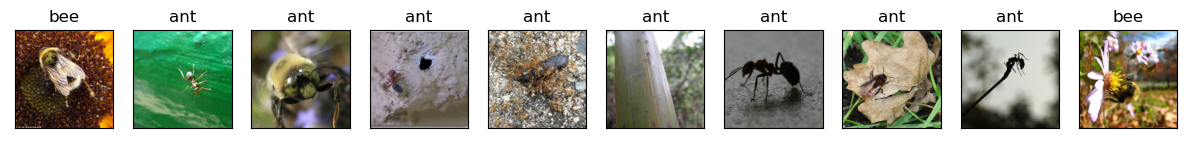

In [11]:
inputs, _ = next(iter(datamodule.default_dataloader(shuffle=True)))

N = 10
model.eval()
inps = torch.cat([inputs[:N]])
model.cpu()
predictions = model.predict(inps).max(1).indices

predicted_labels = [["ant","bee"][p] for p in predictions]
pyplot.figure(figsize=(20, 9))
for i in range(N):
    pyplot.subplot(2, N, i + 1)
    pyplot.title(predicted_labels[i])
    pyplot.imshow(inps[i].permute(1, 2, 0))
    pyplot.xticks([])
    pyplot.yticks([])

## Simulating drifted data

For systematic experiments, we want to compare the output of the drift detector on benign (non-drifted) and and drifted, here (partially) out of distribution samples. We simulate out of distribution data by applying a gaussian blur. In reality you might have effects like the camera lense losing focus or dirt impeding the picture quality.

Note that we do not use the drifted data for "training" the drift detector, but just for evaluation!

On the technical side, we take our datamodule as the in-distribution datamodule as is and use a derived datamodule which applies the gaussian blur in addition to the usual transforms as the out of distribution datamodule.


In [8]:
def corruption_function(x: torch.Tensor):
    return torchdrift.data.functional.gaussian_blur(x, severity=2)

ind_datamodule = datamodule
ood_datamodule = OurDataModule(parent=datamodule, additional_transform=corruption_function)

Let us grab a few inputs and show them. We also let our model predict labels. Sometimes we see that labels are flipped for the blurred images.

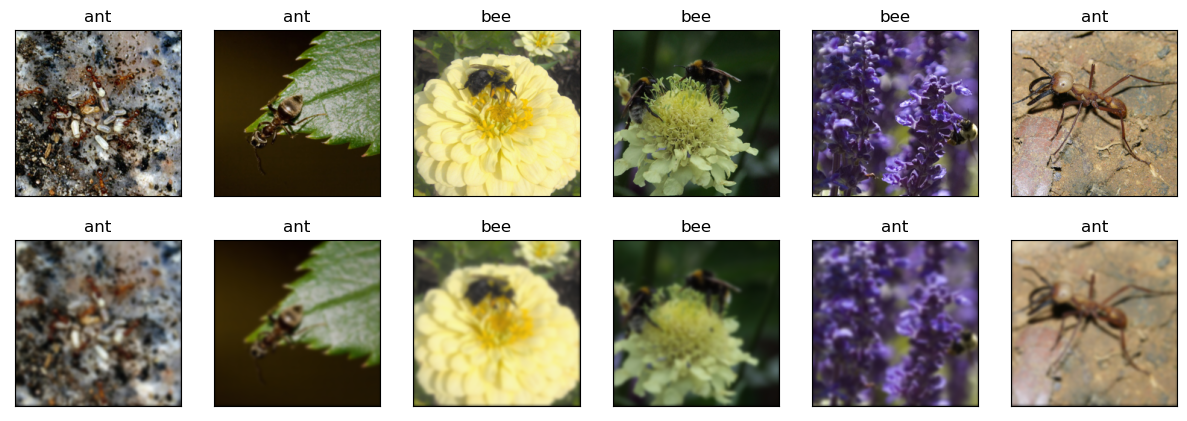

In [9]:
inputs, _ = next(iter(datamodule.default_dataloader(shuffle=True)))
inputs_ood = corruption_function(inputs)

N = 6
model.eval()
inps = torch.cat([inputs[:N], inputs_ood[:N]])
model.cpu()
predictions = model.predict(inps).max(1).indices

predicted_labels = [["ant","bee"][p] for p in predictions]
pyplot.figure(figsize=(15, 5))
for i in range(2 * N):
    pyplot.subplot(2, N, i + 1)
    pyplot.title(predicted_labels[i])
    pyplot.imshow(inps[i].permute(1, 2, 0))
    pyplot.xticks([])
    pyplot.yticks([])

For drift detection, we need a feature extractor (of course, we had one above, too, but let's play along and pretend we got the `model` from our colleague).

In [10]:
feature_extractor = copy.deepcopy(model)
feature_extractor.classifier = torch.nn.Identity()


## The drift detector


We instantiate the drift detector. In this example we use the Kernel MMD drift detector on the features extracted by the pretrained ResNet. We believe this is a good choice for your initial experiments, too.

In [11]:
drift_detector = torchdrift.detectors.KernelMMDDriftDetector()

We fit the drift detector using *benign training data* only. If you have a more sizeable dataset, you likely want to limit the number of samples you use here, you can do this by specifying the `num_batches` parameter to the `fit` function.

In [12]:
torchdrift.utils.fit(datamodule.train_dataloader(), feature_extractor, drift_detector)

100%|██████████| 61/61 [00:02<00:00, 22.23it/s]


We can then put the drift detector to action. TorchDrift uses vanilla `torch.nn.Module`s so you can just build a `Sequential` of the feature extractor and drift detector (or, in other use-cases an additional dimension reduction step in between).


In [13]:
drift_detection_model = torch.nn.Sequential(
    feature_extractor,
    drift_detector
)

First we test the output on benign input. By our setup (see the [overview](./drift_detection_overview.ipynb) for details), we expect the computed p-value to be uniformely distributed on the unit interval $[0, 1]$, so with 95% probability, it is above 0.05.
Note that for the p-value lower means "more likely that things have drifted", while the same leads to higher scores.

In [14]:
features = feature_extractor(inputs)
score = drift_detector(features)
p_val = drift_detector.compute_p_value(features)
score, p_val

(tensor(0.0231), tensor(0.0430))

We can also visualize the two distribution to detemine whether we "intuitively believe" that the two samples are from the same distribution.

You may wonder why we use `Isomap` here instead of the more well-known (in certain circles) `t-SNE`. The reason is that `Isomap` actually gives us a transformation (from the training data) that we can use on the inputs.

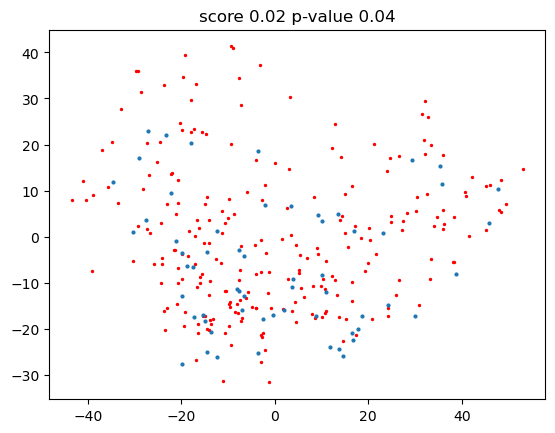

In [15]:
N_base = drift_detector.base_outputs.size(0)
mapper = sklearn.manifold.Isomap(n_components=2)
base_embedded = mapper.fit_transform(drift_detector.base_outputs)
features_embedded = mapper.transform(features)
pyplot.scatter(base_embedded[:, 0], base_embedded[:, 1], s=2, c='r')
pyplot.scatter(features_embedded[:, 0], features_embedded[:, 1], s=4)
pyplot.title(f'score {score:.2f} p-value {p_val:.2f}');

We can also do the same with out of distribution data. Typically the p-value here is very low - that it is actually 0 is an artifact from the bootstrapping we use for computing the p-value.

Can you spot a difference in the plot?

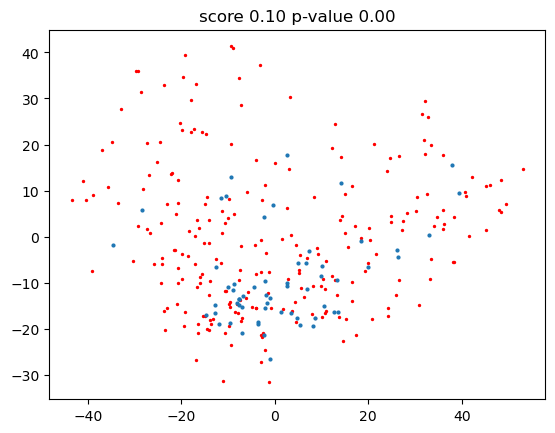

In [16]:
features = feature_extractor(inputs_ood)
score = drift_detector(features)
p_val = drift_detector.compute_p_value(features)

features_embedded = mapper.transform(features)
pyplot.scatter(base_embedded[:, 0], base_embedded[:, 1], s=2, c='r')
pyplot.scatter(features_embedded[:, 0], features_embedded[:, 1], s=4)
pyplot.title(f'score {score:.2f} p-value {p_val:.2f}');

This concludes our overview.

Here, we saw how to get scores and p-values for the drift detection, taking the feature extractor from our classification model (our you might use an imagenet-trained feature extractor regardless of your model).

We show some more systematic experimentation in [Comparing Drift Detectors](./comparing_drift_detectors.ipynb).
Also check our our [example how to use the drift detector in monitoring a model](./deployment_monitoring_example.ipynb).
